In [54]:
import os
import yaml
import fnmatch
from conda_build.metadata import MetaData
from pprint import pprint
import binstar_client
import matplotlib.pyplot as plt
import copy

In [2]:
cli = binstar_client.utils.get_server_api()
packages_on_conda_forge = set([f['full_name'].split('/')[1] for f in cli.show_channel('main', 'conda-forge')['files']])

Using Anaconda Cloud api site https://api.anaconda.org


In [3]:
def sanitize_names(list_of_names):
    list_of_names = [name.split(' ')[0] for name in list_of_names]
    list_of_names = [name for name in list_of_names if name not in packages_on_conda_forge]
    return list_of_names

In [4]:
path = os.path.join(os.path.expanduser("~"), 'dev', 'conda', 'auto-build-tagged-recipes')
build = {}
run = {}
for parent_folder in ['enaml-stack', 'nonpy', 'py2', 'py3', 'pyall', 
                      os.path.join('sort-of-dev-but-actually-tag', 'py3')]:
    for folder in os.listdir(os.path.join(path, parent_folder)):
        if '.yaml' in folder:
            continue
        full_path = os.path.join(parent_folder, folder)
        meta = MetaData(os.path.join(path, full_path))
        name = meta.meta['package']['name']
        if name in packages_on_conda_forge:
            continue
        build[name] = sanitize_names(meta.meta.get('requirements', {}).get('build', []))
        run[name] = sanitize_names(meta.meta.get('requirements', {}).get('run', []))

In [55]:
union = copy.deepcopy(build)
for package, deps in run.items():
    union[package] = set(build.get(package) + run.get(package))

In [58]:
%matplotlib inline
import networkx as nx
kw = dict(node_size=5, node_color='w', edge_color='b', alpha=0.25)

def make_network(packages_dict):
    G = nx.DiGraph()
    for package, deps in packages_dict.items():
#         print(package)
        for dep in deps:
#             print('\t{}'.format(dep))
            G.add_edge(package, dep)
    return G

In [59]:
run_G = make_network(run)
build_G = make_network(build)
all_G = make_network(union)

In [70]:
def trim_nodes(G, d):
    """Returns a copy of G without the nodes with a degree less than d.
    http://glowingpython.blogspot.com/2012/11/first-steps-with-networx.html
    """
    Gt = G.copy()
    dn = nx.degree(Gt)
    for n in Gt.nodes():
        if dn[n] <= d:
            Gt.remove_node(n)
    return Gt

def plot_deps(G, node, function):
    h = nx.from_dict_of_lists({node: getattr(G, function)(node)})
    nx.draw(h, with_labels=True, **kw)


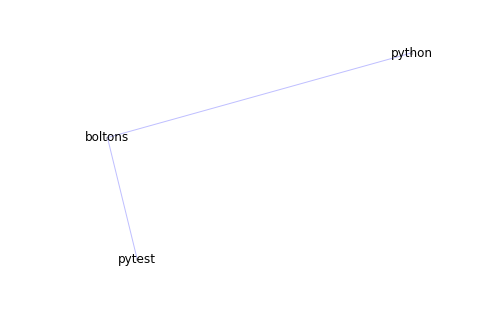

In [73]:
plot_deps(all_G, 'boltons', 'neighbors')

In [75]:
nx.path_graph?

In [76]:
nx.path_graph?

In [77]:
list(nx.strongly_connected_components(all_G))

[{'setuptools'},
 {'python'},
 {'pymongo'},
 {'tzlocal'},
 {'pytest'},
 {'numpy'},
 {'scikit-image'},
 {'slicerator'},
 {'pims'},
 {'boltons'},
 {'channelarchiver'},
 {'pyyaml'},
 {'filestore'},
 {'cytoolz'},
 {'metadatastore'},
 {'requests'},
 {'databroker'},
 {'csxtools'},
 {'cairo-gobject'},
 {'swig'},
 {'bokeh'},
 {'jupyter'},
 {'scipy'},
 {'super_state_machine'},
 {'epics-base'},
 {'pyepics'},
 {'prettytable'},
 {'ophyd'},
 {'hdf5-lz4'},
 {'pyqt'},
 {'suitcase'},
 {'openpyxl'},
 {'pytables'},
 {'conda-env'},
 {'conda_etc'},
 {'lmfit'},
 {'ixstools'},
 {'xray-vision'},
 {'historydict'},
 {'event-model'},
 {'bluesky'},
 {'datamuxer'},
 {'flask'},
 {'album'},
 {'scikit-beam'},
 {'analysis'},
 {'hgtools'},
 {'keyring'},
 {'pyolog'},
 {'fabio'},
 {'pip'},
 {'args'},
 {'clint'},
 {'kiwisolver'},
 {'numba'},
 {'future'},
 {'atom'},
 {'sphinx'},
 {'pcaspy'},
 {'ply'},
 {'gobject-introspection'},
 {'py3cairo'},
 {'pygobject3'},
 {'hkl'},
 {'pyasn1'},
 {'numexpr'},
 {'sphinx-bootstrap-theme

In [104]:
print("Build Order")
for idx, item in enumerate(reversed(nx.topological_sort(all_G))):
    print('{:>2}: {}'.format(idx, item))

Build Order
 0: python
 1: setuptools
 2: pymongo
 3: requests
 4: numpy
 5: pytest
 6: boltons
 7: pyyaml
 8: metadatastore
 9: slicerator
10: scikit-image
11: pims
12: cytoolz
13: filestore
14: tzlocal
15: channelarchiver
16: databroker
17: csxtools
18: cairo-gobject
19: swig
20: bokeh
21: jupyter
22: scipy
23: super_state_machine
24: prettytable
25: epics-base
26: pyepics
27: ophyd
28: hdf5-lz4
29: pyqt
30: suitcase
31: openpyxl
32: pytables
33: conda-env
34: conda_etc
35: lmfit
36: ixstools
37: scikit-beam
38: flask
39: album
40: datamuxer
41: xray-vision
42: event-model
43: historydict
44: bluesky
45: analysis
46: hgtools
47: keyring
48: pyolog
49: fabio
50: pip
51: args
52: clint
53: kiwisolver
54: numba
55: future
56: atom
57: sphinx
58: pcaspy
59: ply
60: gobject-introspection
61: py3cairo
62: pygobject3
63: hkl
64: pyasn1
65: numexpr
66: sphinx-bootstrap-theme
67: enaml
68: characteristic
69: docutils
70: trackpy
71: collection
72: pyxrf
73: chxtools
74: pyasn1-modules
75: pyo

In [93]:
import uuid
start = order[0]
nodes = [order[0]] # start with first node in topological order
labels = {}
print("edges")
tree = nx.Graph()
idx = 0
while nodes:
    idx += 1
    source = nodes.pop()
    labels[source] = str(idx) + '-' + source
    for target in all_G.neighbors(source):
        if target in tree:
            t = uuid.uuid1() # new unique id
        else:
            t = target
        labels[t] = target
        tree.add_edge(source,t)
        print(source,target,source,t)
        nodes.append(target)

edges
eiger-io filestore eiger-io filestore
eiger-io numpy eiger-io numpy
eiger-io pims eiger-io pims
eiger-io setuptools eiger-io setuptools
eiger-io python eiger-io python
pims numpy pims dc204292-1bda-11e6-8a27-7c7a91b4df7f
pims scikit-image pims scikit-image
pims setuptools pims dc20494a-1bda-11e6-8a27-7c7a91b4df7f
pims python pims dc204d0a-1bda-11e6-8a27-7c7a91b4df7f
pims slicerator pims slicerator
slicerator setuptools slicerator dc205070-1bda-11e6-8a27-7c7a91b4df7f
slicerator python slicerator dc205318-1bda-11e6-8a27-7c7a91b4df7f
filestore pyyaml filestore pyyaml
filestore boltons filestore boltons
filestore python filestore dc205714-1bda-11e6-8a27-7c7a91b4df7f
filestore pymongo filestore pymongo
filestore numpy filestore dc205980-1bda-11e6-8a27-7c7a91b4df7f
filestore pims filestore dc205b2e-1bda-11e6-8a27-7c7a91b4df7f
pims numpy pims dc205d0e-1bda-11e6-8a27-7c7a91b4df7f
pims scikit-image pims dc205ebc-1bda-11e6-8a27-7c7a91b4df7f
pims setuptools pims dc206092-1bda-11e6-8a27-7c7a

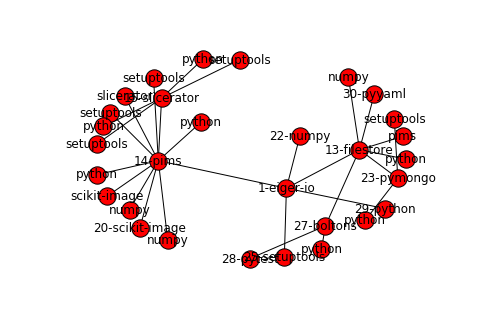

In [94]:
%matplotlib inline
plt.figure()
nx.draw(tree, labels=labels)


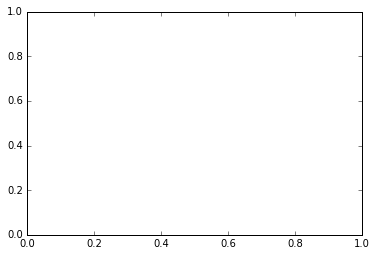

In [80]:
plt.subplots()
nx.traversal.bfs_tree(all_G, 'enaml')